In [1]:
import os
for dirname, _, filenames in os.walk('data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

data/test.csv
data/train.csv
data/.ipynb_checkpoints/train-checkpoint.csv


In [2]:
import pyspark

conf = pyspark.SparkConf()
conf.set('spark.ui.proxyBase', '/user/' + os.environ['JUPYTERHUB_USER'] + '/proxy/4041')
conf.set('spark.sql.repl.eagerEval.enabled', True)
conf.set('spark.driver.memory','4g')

sc = pyspark.SparkContext(conf=conf)
sc.setLogLevel("ERROR")
spark = pyspark.SQLContext.getOrCreate(sc)


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/12/05 15:08:45 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


/opt/conda/envs/bigdata-fall22/lib/python3.7/site-packages/pyspark/sql/context.py:159: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning,


In [3]:
#del traindf,testdf
traindf = spark.read.options(inferSchema="True",header='True').csv('data/train.csv')
testdf  = spark.read.options(inferSchema="True",header='True').csv('data/test.csv')
print("Train set size: {} and test set size: {}".format((traindf.count(), len(traindf.columns)),(testdf.count(), len(testdf.columns))))

Train set size: (31962, 3) and test set size: (17197, 2)


In [4]:
traindf.limit(5).toPandas()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [5]:
testdf.limit(5).toPandas()

,id,tweet
0,31963,#studiolife #aislife #requires #passion #dedic...
1,31964,@user #white #supremacists want everyone to s...
2,31965,safe ways to heal your #acne!! #altwaystohe...
3,31966,is the hp and the cursed child book up for res...
4,31967,"3rd #bihday to my amazing, hilarious #nephew..."


In [6]:
from pyspark.sql.functions import col

traindf_duplicates = traindf.groupBy("tweet","label").count().filter(col("count")>1)
testdf_duplicates = testdf.groupBy("tweet").count().filter(col("count")>1)

if traindf_duplicates.count()>0:
    print("Total number of duplicates in train data:",traindf_duplicates.agg({'count': 'sum'}).collect()[0][0])
else:
    print("No duplicates in train data")
    
if testdf_duplicates.count()>0:
    print("Total number of duplicates in test data:",testdf_duplicates.agg({'count': 'sum'}).collect()[0][0])
else:
    print("No duplicates in test data")
    


Total number of duplicates in train data: 3130
Total number of duplicates in test data: 1422


In [7]:
traindf=traindf.dropDuplicates(["tweet","label"])
testdf=testdf.dropDuplicates(["tweet"])

#Remove rows with any Null/None values in any of the coloumns
traindf.na.drop(how="any",subset=["tweet","label"])
testdf.na.drop(how="any",subset=["tweet"])

print("New Train set size: {} and New test set size: {}".format((traindf.count(), len(traindf.columns)),(testdf.count(), len(testdf.columns))))

New Train set size: (29528, 3) and New test set size: (16130, 2)


In [8]:
pos = 100*traindf.where(traindf.label == 0).count()/traindf.count()
neg = 100*traindf.where(traindf.label == 1).count()/traindf.count()
print(f'Percentage of Negative Sentiment tweets is {pos}')
print(f'Percentage of Postitive Sentiment tweets is {neg}')

Percentage of Negative Sentiment tweets is 93.18274180438905
Percentage of Postitive Sentiment tweets is 6.817258195610946


In [9]:
traindfpos =traindf.where(traindf.label == 0)
traindfneg =traindf.where(traindf.label == 1)
traindfpos.show()

+----+-----+--------------------+
|  id|label|               tweet|
+----+-----+--------------------+
| 258|    0|" @user @user on ...|
| 324|    0|"hey, i noticed t...|
| 356|    0|@user nothing say...|
| 661|    0|the h factor! doe...|
| 749|    0|my friends magica...|
| 754|    0|nyc in seven days...|
| 821|    0|i was founate to ...|
|1034|    0|_  #windows10 spl...|
|1417|    0|my first performa...|
|1905|    0|  @user goddamn it. |
|1906|    0|@user  you are wi...|
|2009|    0|let's go!!! #weez...|
|2056|    0|people complain a...|
|2190|    0|arjun #suit relea...|
|2591|    0| @user lovely to ...|
|2655|    0|first major spos ...|
|2812|    0|you know today is...|
|2882|    0|it's time!!! #oit...|
|2890|    0|no #rum no #monta...|
|3025|    0|here to do yoga i...|
+----+-----+--------------------+
only showing top 20 rows



In [10]:
import re
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from nltk.corpus import stopwords
import nltk
#nltk.download('stopwords')
stopwordsList=stopwords.words('english')
stopwordsList.extend(["amp"])

@udf(returnType=StringType())
def getHashtags(tweet):
    l=re.findall("#([a-zA-Z0-9_]{1,50})", tweet)
    l=[tag for tag in l if tag.strip()!=""]
    return ' '.join(l)

@udf(returnType=StringType())
def getCleanedTweet(tweet):
    CT = re.sub("@[A-Za-z0-9_]+","", tweet)
    CT = re.sub("#[A-Za-z0-9_]+","", CT)
    CT = re.sub('[^a-z]+', ' ', CT)
    CT = ' '.join([word for word in CT.split() if not word in stopwordsList]).lower()
    return CT.strip()


traindfpos=traindfpos.withColumn("Hashtags",getHashtags("tweet"))
traindfpos=traindfpos.withColumn("CleanTweet",getCleanedTweet("tweet"))

traindfneg=traindfneg.withColumn("Hashtags",getHashtags("tweet"))
traindfneg=traindfneg.withColumn("CleanTweet",getCleanedTweet("tweet"))

traindfneg.show(20)

+-----+-----+--------------------+--------------------+--------------------+
|   id|label|               tweet|            Hashtags|          CleanTweet|
+-----+-----+--------------------+--------------------+--------------------+
| 2006|    1|@user why the #el...|electoralcollege ...|   elects presidents|
| 2639|    1|@user if i cud  t...|blackonblack ris2...|           cud x wud|
| 8627|    1|expressions of , ...|misandry misogyny...|expressions ie pa...|
|10307|    1|#boycott #lying #...|boycott lying div...|      add list karma|
|12717|    1|the end of   #me ...|me selfie love me...|                 end|
|16877|    1|#newyearseve fact...|newyearseve islam...|factophobia ale p...|
|17138|    1|pay porn free vid...|                    |pay porn free vid...|
|18886|    1|it impossible to ...|                 god|impossible hatefu...|
|19096|    1|@user i hate you ...|corruption bankru...|                hate|
|19235|    1|@user the main st...|                    |main stream news ...|

In [11]:
#traindfpos.filter(col("tweet").contains("amp")).show(truncate=False)

In [12]:
from pyspark.sql.functions import size,split,explode

traindfposf = traindfpos.withColumn('HashtagsCount', size(split(col('Hashtags'), ' ')))
traindfposf = traindfposf.withColumn('TweetWordCount', size(split(col('CleanTweet'), ' ')))
#traindfposf.show()

traindfnegf = traindfneg.withColumn('HashtagsCount', size(split(col('Hashtags'), ' ')))
traindfnegf = traindfnegf.withColumn('TweetWordCount', size(split(col('CleanTweet'), ' ')))
#traindfnegf.show()

Traceback (most recent call last):
  File "/opt/conda/envs/bigdata-fall22/lib/python3.7/site-packages/pyspark/python/lib/pyspark.zip/pyspark/daemon.py", line 187, in manager
  File "/opt/conda/envs/bigdata-fall22/lib/python3.7/site-packages/pyspark/python/lib/pyspark.zip/pyspark/daemon.py", line 74, in worker
  File "/opt/conda/envs/bigdata-fall22/lib/python3.7/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 719, in main
    report_times(outfile, boot_time, init_time, finish_time)
  File "/opt/conda/envs/bigdata-fall22/lib/python3.7/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 73, in report_times
    write_long(int(1000 * init), outfile)
  File "/opt/conda/envs/bigdata-fall22/lib/python3.7/site-packages/pyspark/python/lib/pyspark.zip/pyspark/serializers.py", line 585, in write_long
    stream.write(struct.pack("!q", value))
ConnectionResetError: [Errno 104] Connection reset by peer


In [13]:
Frequency=traindfnegf.withColumn('word', explode(split(col('CleanTweet'), ' ')))\
    .groupBy('word')\
    .count().filter(col("word") !="")\
    .sort('count', ascending=False).withColumnRenamed("count", "frequency")

hashtagsfrequency=traindfnegf.filter(col("CleanTweet") !="").withColumn('hashtag', explode(split(col('Hashtags'), ' ')))\
    .groupBy('hashtag')\
    .count().filter(col("hashtag") !="")\
    .sort('count', ascending=False).withColumnRenamed("count", "frequency")

Frequencyf=traindfposf.withColumn('word', explode(split(col('CleanTweet'), ' ')))\
    .groupBy('word')\
    .count().filter(col("word") !="")\
    .sort('count', ascending=False).withColumnRenamed("count", "frequency")

hashtagsfrequencyf=traindfposf.withColumn('hashtag', explode(split(col('Hashtags'), ' ')))\
    .groupBy('hashtag')\
    .count().filter(col("hashtag") !="")\
    .sort('count', ascending=False).withColumnRenamed("count", "frequency")



Frequency.limit(20).show()

hashtagsfrequency.limit(5).show()

+--------+---------+
|    word|frequency|
+--------+---------+
|   white|      124|
|    like|      100|
|  racist|       93|
|   black|       90|
|  people|       81|
|   women|       67|
|   trump|       65|
|  racism|       65|
|     new|       62|
|      us|       49|
|     one|       47|
|   right|       46|
|   obama|       45|
|     via|       43|
|   woman|       40|
|    hate|       38|
|     men|       38|
|comments|       37|
|    stop|       36|
|   would|       35|
+--------+---------+

+---------+---------+
|  hashtag|frequency|
+---------+---------+
|    trump|      120|
|allahsoil|       89|
|     hate|       32|
|   brexit|       27|
|    bigot|       27|
+---------+---------+



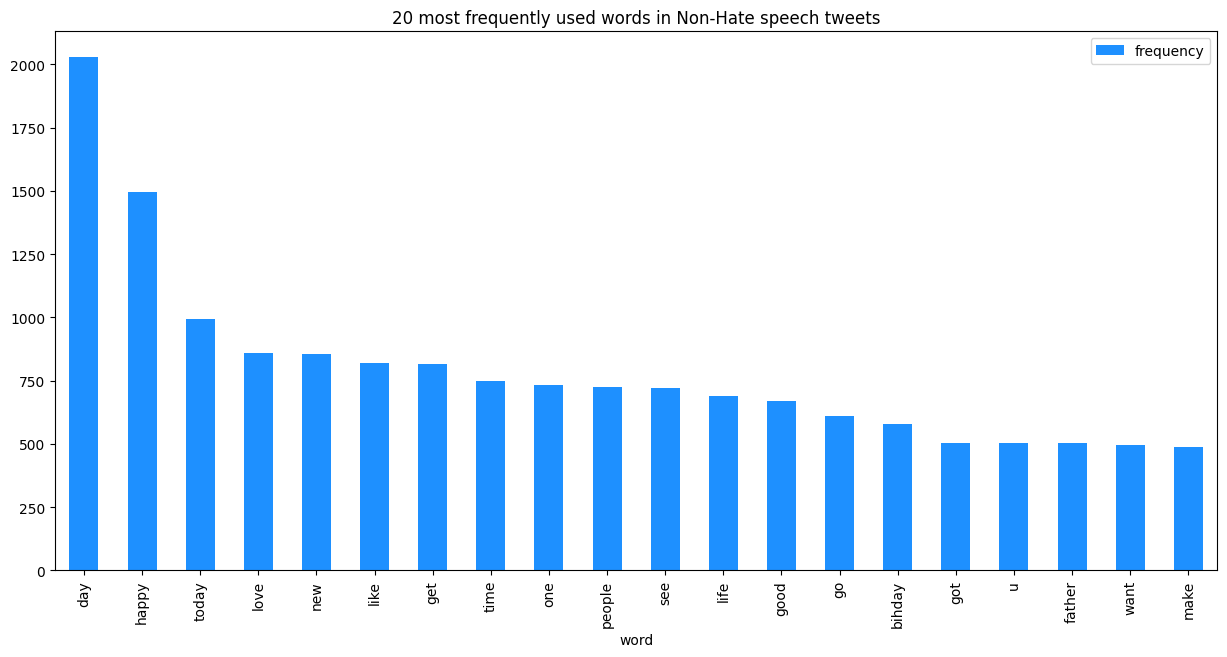

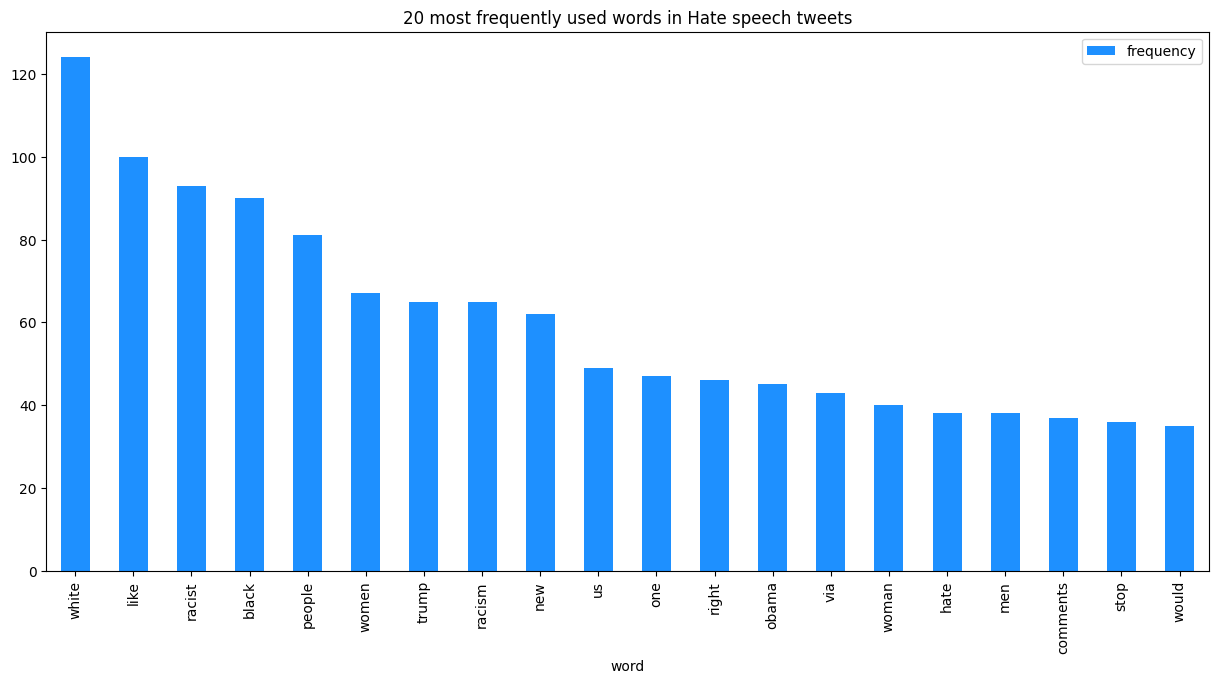

In [14]:
import matplotlib.pyplot as plt

Frequencyf.limit(20).toPandas().plot(x='word', y='frequency', kind='bar', figsize=(15, 7), color = 'dodgerblue')
plt.title("20 most frequently used words in Non-Hate speech tweets")
plt.show()


Frequency.limit(20).toPandas().plot(x='word', y='frequency', kind='bar', figsize=(15, 7), color = 'dodgerblue')
plt.title("20 most frequently used words in Hate speech tweets")
plt.show()


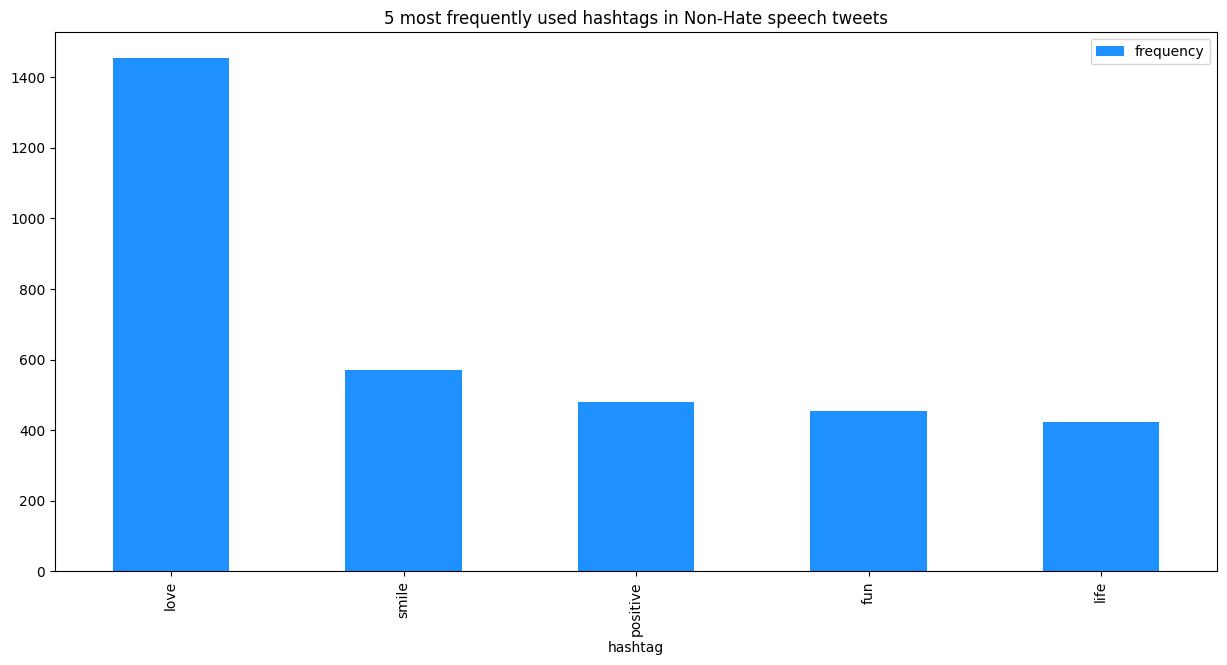

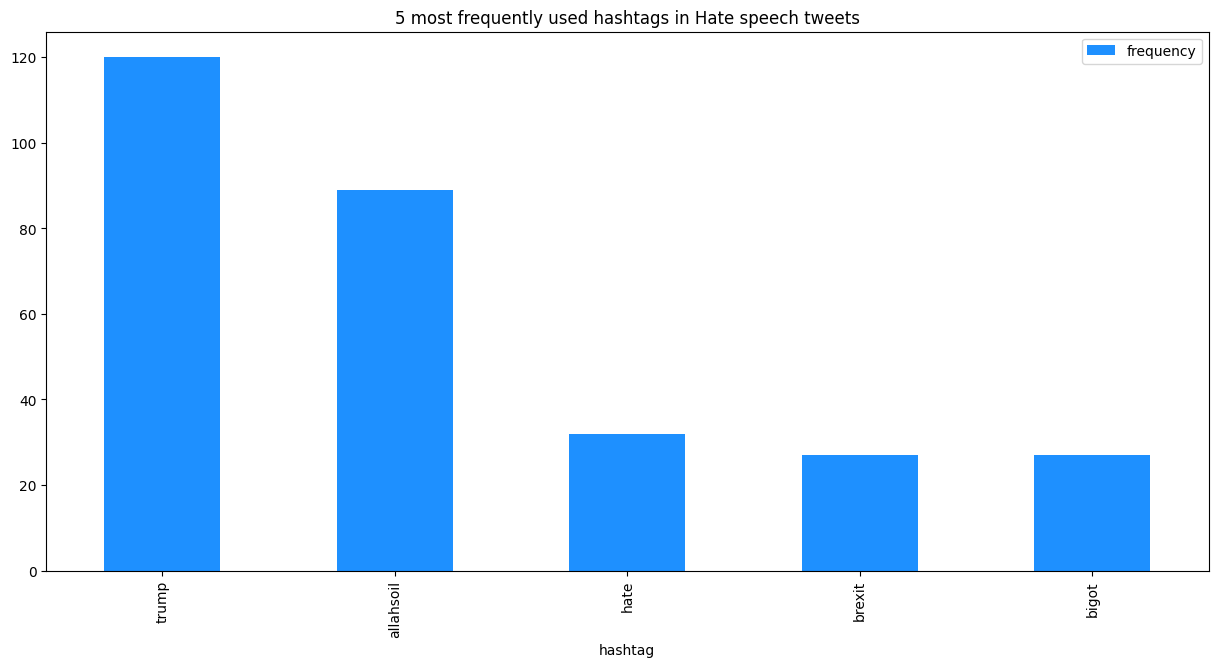

In [15]:


hashtagsfrequencyf.limit(5).toPandas().plot(x='hashtag', y='frequency', kind='bar', figsize=(15, 7), color = 'dodgerblue')
plt.title("5 most frequently used hashtags in Non-Hate speech tweets")
plt.show()

hashtagsfrequency.limit(5).toPandas().plot(x='hashtag', y='frequency', kind='bar', figsize=(15, 7), color = 'dodgerblue')
plt.title("5 most frequently used hashtags in Hate speech tweets")
plt.show()
